In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
# Use for conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [100]:
df = pd.read_csv('../data/cleaned_study_data/sub1_inc_clean.csv')

In [101]:
# Set 'time' as the index
df.set_index('time', inplace= True)
df.head()

Power    Oxygen  Cadence    HR    RF  session_time  hr_p_fatigue
time                                                                  
3       0.0  602.0000      0.0  86.0  16.0             0          86.0
4       0.0  578.1250      0.0  86.0  16.0             1          86.0
5       0.0  558.7500      0.0  86.0  16.0             2          86.0
6       0.0  542.1875      0.0  86.0  16.0             3          86.0
7       0.0  527.5000      0.0  86.0  16.0             4          86.0

In [102]:
# Scaling the data
mm_scaler = MinMaxScaler()
data_scaled = mm_scaler.fit_transform(df)

In [103]:
features = data_scaled
target = data_scaled[:,3] # HR is the target

In [104]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= 0.2, shuffle= False, random_state = 42)

In [105]:
X_train.shape

(2264, 7)

In [106]:
X_test.shape

(567, 7)

In [107]:
y_train.shape

(2264,)

In [108]:
y_test.shape

(567,)

In [79]:
win_length = 60
batch_size= 32
num_features = 7

# Create training sequences
train_generator = TimeseriesGenerator(X_train, y_train, length= win_length, sampling_rate= 1, batch_size= batch_size )

# Create test sequences
test_generator = TimeseriesGenerator(X_test, y_test, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [30]:
train_generator[0][0].shape

(32, 60, 7)

In [31]:
# LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences= False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           69632     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience= 5,
                                                 mode= 'min')

model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
              #metrics= [tf.metrics.MeanAbsoluteError()]
             )

history = model.fit(train_generator, epochs= 300,
                              validation_data= test_generator,
                              shuffle= False
                              #callbacks= [early_stopping]
                             )

Epoch 1/300
69/69 [==============================] - 2s 35ms/step - loss: 0.0111 - val_loss: 0.0196
Epoch 2/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0109 - val_loss: 0.0305
Epoch 3/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0132 - val_loss: 0.0154
Epoch 4/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0093 - val_loss: 0.0258
Epoch 5/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0076 - val_loss: 0.0229
Epoch 6/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0141 - val_loss: 0.0213
Epoch 7/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0057 - val_loss: 0.0683
Epoch 8/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0237 - val_loss: 0.0801
Epoch 9/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0100 - val_loss: 0.0779
Epoch 10/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0050 - val_loss: 0.0074

In [109]:
train_preds = model.predict(train_generator)
test_preds = model.predict(test_generator)

In [110]:
r2_score(y_train[win_length:], train_preds), r2_score(y_test[win_length:], test_preds)

(0.9832265450502858, 0.879353555814933)

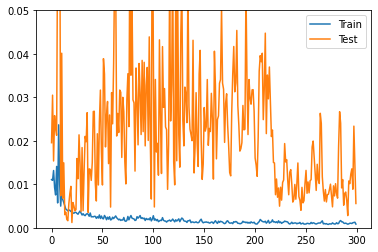

In [111]:
plt.plot(history.history['loss'], label= 'Train')
plt.plot(history.history['val_loss'], label= 'Test')
plt.legend()
plt.ylim(0, .05);

In [130]:
hr_test_results_sc = pd.DataFrame(X_test[win_length:])

In [131]:
hr_test_results_sc[3] = test_preds

In [132]:
hr_test_results_sc.head(10)

0         1    2         3         4         5         6
0  1.0  0.951160  1.0  0.926187  0.905862  0.821201  0.075041
1  1.0  0.952089  1.0  0.921486  0.900039  0.821555  0.069284
2  1.0  0.958853  1.0  0.917163  0.903921  0.821908  0.069284
3  1.0  0.960236  1.0  0.913563  0.900039  0.822261  0.069284
4  1.0  0.959004  1.0  0.911484  0.903921  0.822615  0.069284
5  1.0  0.962721  1.0  0.910891  0.918478  0.822968  0.069284
6  1.0  0.972057  1.0  0.910776  0.941770  0.823322  0.069284
7  1.0  0.972165  1.0  0.909861  0.953416  0.823675  0.069284
8  1.0  0.967930  1.0  0.908220  0.970885  0.824028  0.069284
9  1.0  0.976077  1.0  0.905871  1.000000  0.824382  0.069284

In [133]:
# Column '3' is y_test predictions, de-scaled
hr_test_results = pd.DataFrame(mm_scaler.inverse_transform(hr_test_results_sc))
hr_test_results.head(10)

0       1     2           3      4       5     6
0  380.0  4506.6  90.0  170.161866  57.25  2324.0  76.6
1  380.0  4510.9  90.0  169.700907  56.95  2325.0  76.0
2  380.0  4542.2  90.0  169.277034  57.15  2326.0  76.0
3  380.0  4548.6  90.0  168.923942  56.95  2327.0  76.0
4  380.0  4542.9  90.0  168.720156  57.15  2328.0  76.0
5  380.0  4560.1  90.0  168.662000  57.90  2329.0  76.0
6  380.0  4603.3  90.0  168.650650  59.10  2330.0  76.0
7  380.0  4603.8  90.0  168.560990  59.70  2331.0  76.0
8  380.0  4584.2  90.0  168.400076  60.60  2332.0  76.0
9  380.0  4621.9  90.0  168.169673  62.10  2333.0  76.0

In [146]:
# This is X_test, de-scaled (Original)
df[:][-507:].reset_index()['HR'].head(10)

0    171.6
1    171.0
2    171.0
3    171.0
4    171.0
5    171.0
6    171.0
7    171.0
8    171.0
9    171.0
Name: HR, dtype: float64

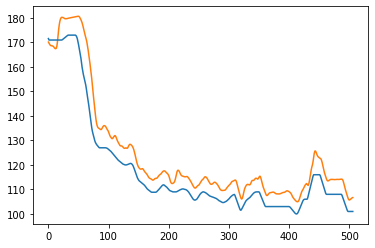

In [147]:
plt.plot(hr_test_results[3], color = 'tab:orange')
plt.plot(df[:][-507:].reset_index()['HR'], color= 'tab:blue');

In [80]:
# RNN Design

gru_model = Sequential()

gru_model.add(GRU(8, input_shape= (win_length, num_features), return_sequences=True)) # True if the next layer is RNN
gru_model.add(GRU(8, return_sequences=False)) # False if the next layer is Dense
gru_model.add(Dense(8, activation='relu'))
gru_model.add(tf.keras.layers.Dropout(0.5))
gru_model.add(Dense(4, activation='relu'))
gru_model.add(tf.keras.layers.Dropout(0.3))
gru_model.add(Dense(7, activation='sigmoid'))

gru_model.compile(loss='mse', optimizer=Adam(lr=.0005), metrics= 'mse')

In [81]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience= 30,
                                                 mode= 'min')

gru_model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
              #metrics= [tf.metrics.MeanAbsoluteError()]
             )

gru_history = gru_model.fit(train_generator, epochs= 500,
                              validation_data= test_generator,
                              shuffle= False,
                              callbacks= [early_stopping]
                             )

Epoch 1/500
69/69 [==============================] - 1s 13ms/step - loss: 0.0966 - val_loss: 0.1510
Epoch 2/500
69/69 [==============================] - 1s 8ms/step - loss: 0.0885 - val_loss: 0.1509
Epoch 3/500
69/69 [==============================] - 1s 7ms/step - loss: 0.0830 - val_loss: 0.1497
Epoch 4/500
69/69 [==============================] - 1s 7ms/step - loss: 0.0780 - val_loss: 0.1529
Epoch 5/500
69/69 [==============================] - 1s 7ms/step - loss: 0.0731 - val_loss: 0.1533
Epoch 6/500
69/69 [==============================] - 1s 8ms/step - loss: 0.0688 - val_loss: 0.1517
Epoch 7/500
69/69 [==============================] - 1s 7ms/step - loss: 0.0647 - val_loss: 0.1549
Epoch 8/500
69/69 [==============================] - 1s 7ms/step - loss: 0.0615 - val_loss: 0.1517
Epoch 9/500
69/69 [==============================] - 1s 7ms/step - loss: 0.0585 - val_loss: 0.1446
Epoch 10/500
69/69 [==============================] - 0s 7ms/step - loss: 0.0549 - val_loss: 0.1394
Epoch 11

In [82]:
gru_train_preds = gru_model.predict(train_generator)
gru_test_preds = gru_model.predict(test_generator)

In [88]:
#r2_score(y_train[win_length:], gru_train_preds), r2_score(y_test[win_length:], gru_test_preds)

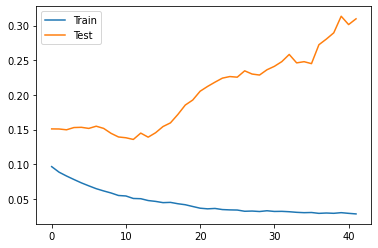

In [83]:
plt.plot(gru_history.history['loss'], label= 'Train')
plt.plot(gru_history.history['val_loss'], label= 'Test')
plt.legend()
#plt.ylim(0, .05);

In [84]:
gru_train_preds_df = pd.DataFrame(gru_train_preds)
#gru_train_preds_df.head(50)

In [85]:
#pd.DataFrame(y_test[3:])

In [87]:
pd.DataFrame(mm_scaler.inverse_transform(gru_train_preds_df))

0            1          2           3          4            5  \
0     101.005600  1678.866211  77.418106  110.238457  24.101374   770.512207   
1     100.941826  1678.188354  77.434853  110.218384  24.096031   769.945435   
2     100.940239  1678.171509  77.435272  110.217896  24.095898   769.931335   
3     101.025017  1679.072876  77.413002  110.244583  24.103004   770.684937   
4     101.175774  1680.674927  77.373352  110.292030  24.115633   772.025085   
...          ...          ...        ...         ...        ...          ...   
2199  348.515228  4214.423828  89.999519  173.106979  37.904427  1937.257080   
2200  348.511383  4214.373535  89.999519  173.106339  37.903831  1937.223633   
2201  348.505737  4214.302246  89.999519  173.105423  37.903111  1937.178955   
2202  348.506134  4214.306641  89.999519  173.105515  37.903259  1937.184326   
2203  348.511536  4214.376465  89.999519  173.106400  37.904011  1937.228882   

              6  
0     88.282158  
1     88.274277  
2     88.274086  
3     88.284554  
4     88.303177  
...         ...  
2199  85.776466  
2200  85.776817  
2201  85.777306  
2202  85.777260  
2203  85.776779  

[2204 rows x 7 columns]